<a href="https://colab.research.google.com/github/iamvarada/colab_ML/blob/main/CNN_applying_overfitting_prevention_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Applying techniques for avoiding overfitting

## 1. Image augmentation

# Want to identify the main subject (say dogs) wherever they are in the image (to the side, corner etc..). If training set
# does not have these cases, then CNN does not generalize enough.

## Hence image augmentaiton.. augment the image by applying transformaton (usually rotation, flipping, zoom) to create new images
# and add to the dataset

# 2. Dropout
# During training one part of neurons can end up with very high weight compared to other neurons.
# So for dropping out, we randomly turn off some neurons and perform feed forward and backprop.
# Hence, network becomes more resellient.

# 3. Early stopping
# If validation loss starts to increase after a certain number of epochs (say 50/60 epochs), stop training after 50 epochs

In [2]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Download dataset from kaggle

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68606236/68606236 [==============================] - 4s 0us/step


In [4]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
# understanding the data

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print("total training cat images", num_cats_tr)
print("total training dog images", num_dogs_tr)
print("total validation cat images", num_cats_val)
print("total validation dog images", num_dogs_val)

print("total training images", total_train)
print("total validation images", total_val)

total training cat images 1000
total training dog images 1000
total validation cat images 500
total validation dog images 500
total training images 2000
total validation images 1000


In [6]:
# Model params

BATCH_SIZE = 100 # Number of training examples to pass to the model in every epoch while traing before updating weights 
IMG_SHAPE = 150  # Re-sizing images of different size to same size so that we can input it to the model

In [7]:
# Visualize the training data

# Function to plot certain number of images in row vector
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize = (20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

In [8]:
# Data preparation -- "Image augmentation"

# flipping
image_gen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True) # Rescale to be b/w 0 to 1 as NN prefer small inputs

train_data_gen = image_gen.flow_from_directory(batch_size = BATCH_SIZE, directory = train_dir,
                                                           shuffle = True, target_size = (IMG_SHAPE, IMG_SHAPE),
                                                            class_mode = 'binary'
                                                           )

Found 2000 images belonging to 2 classes.


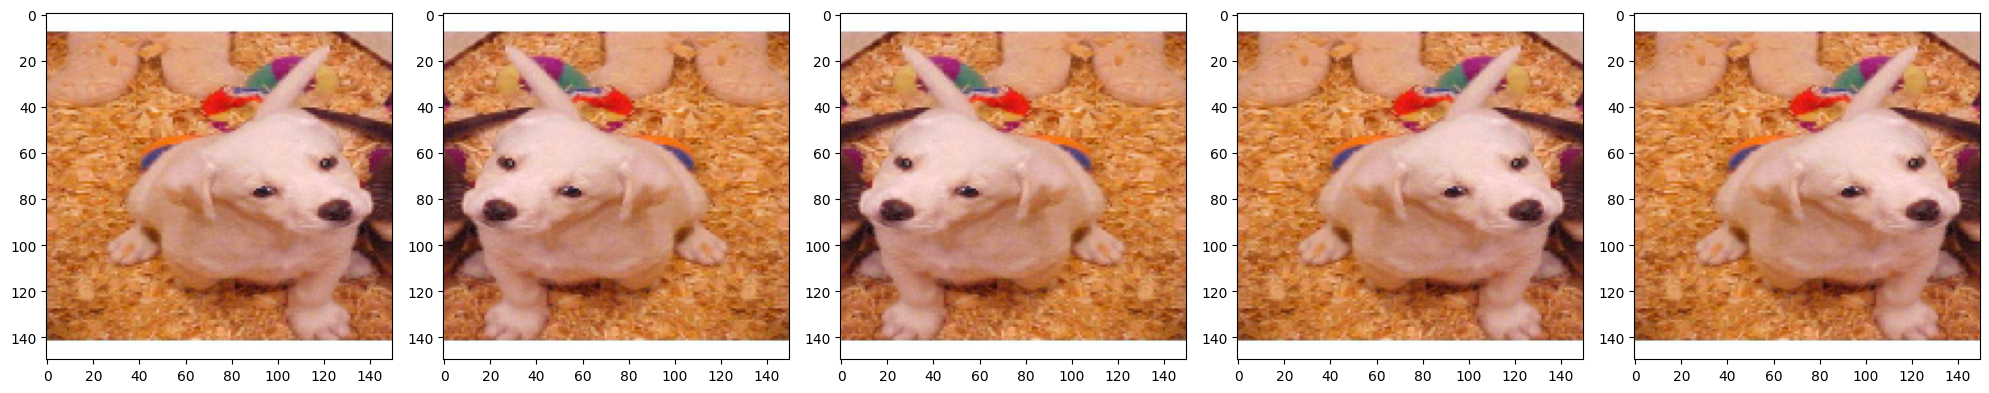

In [9]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images) ## Notice some images are flipped on horizontal axis


Found 2000 images belonging to 2 classes.


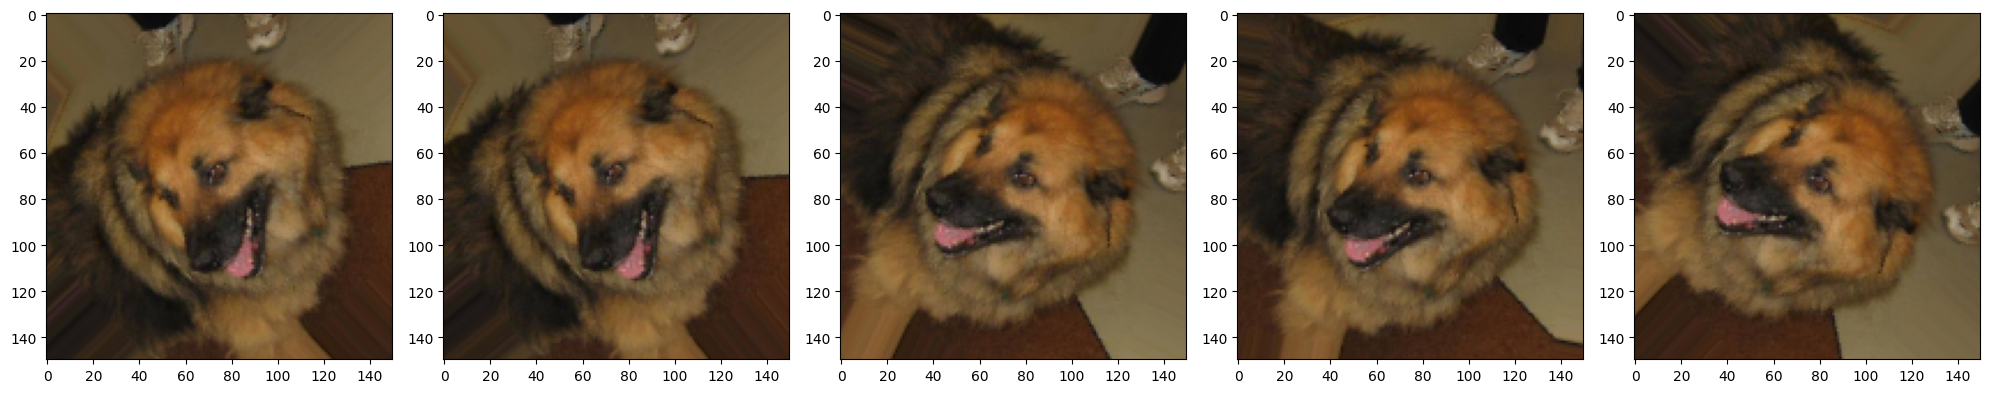

In [10]:
# Rotating the images
image_gen = ImageDataGenerator(rescale = 1./255, rotation_range = -45) # Rescale to be b/w 0 to 1 as NN prefer small inputs

train_data_gen = image_gen.flow_from_directory(batch_size = BATCH_SIZE, directory = train_dir,
                                                           shuffle = True, target_size = (IMG_SHAPE, IMG_SHAPE),
                                                            class_mode = 'binary'
                                              )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images) ## Notice some images are rotate


Found 2000 images belonging to 2 classes.


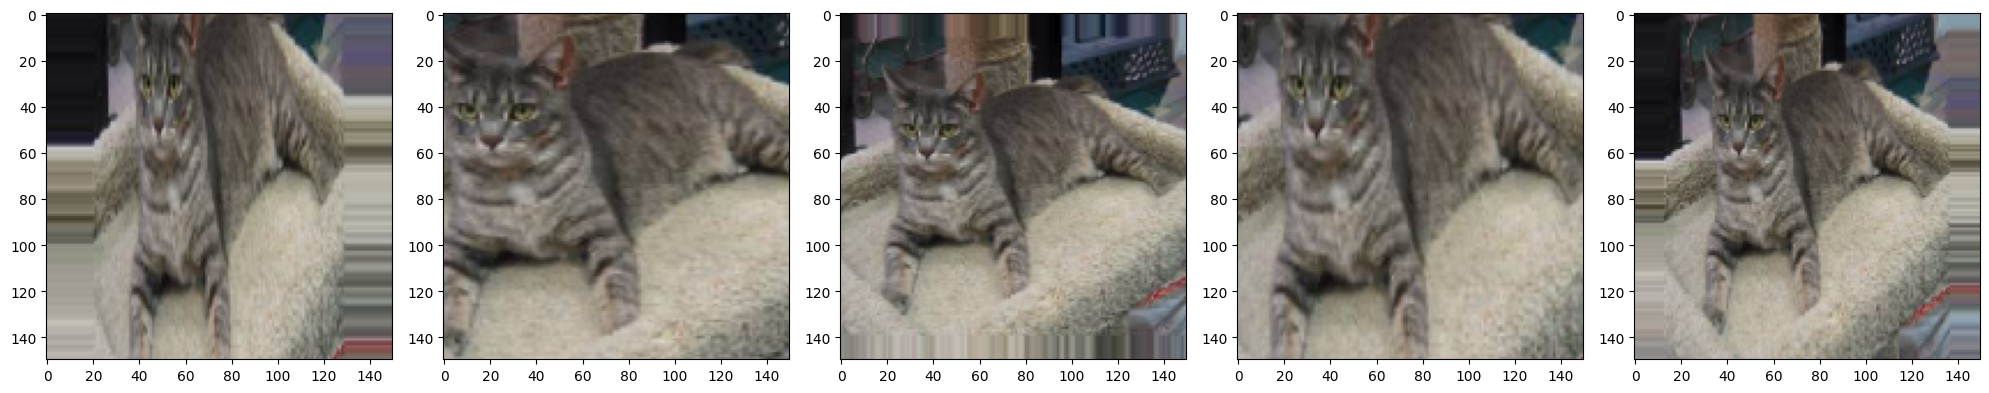

In [11]:
# Zooming the image
image_gen = ImageDataGenerator(rescale = 1./255, zoom_range=0.4) # Rescale to be b/w 0 to 1 as NN prefer small inputs

train_data_gen = image_gen.flow_from_directory(batch_size = BATCH_SIZE, directory = train_dir,
                                                           shuffle = True, target_size = (IMG_SHAPE, IMG_SHAPE),
                                                            class_mode = 'binary'
                                              )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images) ## Notice some images are zommed in


Found 2000 images belonging to 2 classes.


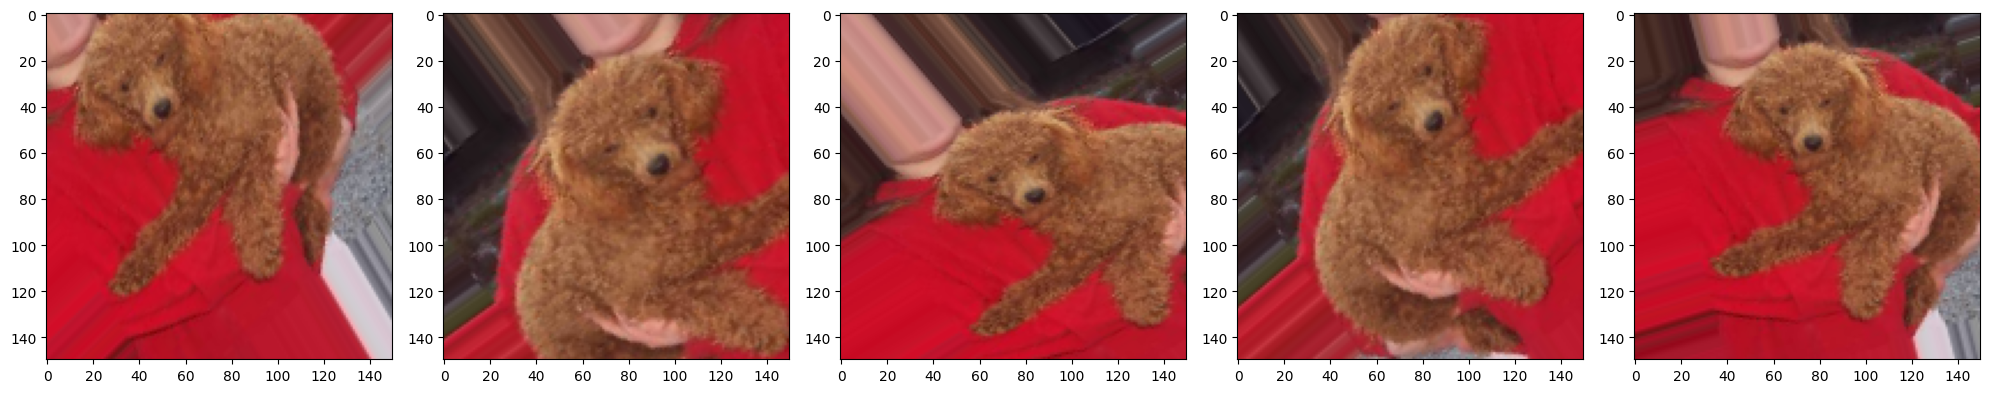

In [12]:
## Combining all image operations into one
image_gen_train = ImageDataGenerator(rescale = 1./255, # Rescale to be b/w 0 to 1 as NN prefer small inputs
                                     zoom_range=0.2,
                                     rotation_range=40,
                                     width_shift_range = 0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest'
                                     ) 

train_data_gen = image_gen_train.flow_from_directory(batch_size = BATCH_SIZE, directory = train_dir,
                                                           shuffle = True, target_size = (IMG_SHAPE, IMG_SHAPE),
                                                            class_mode = 'binary'
                                              )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images) # notice the output iamges have combination of all of these operations


In [13]:
# validation dataset

validation_image_generator = ImageDataGenerator(rescale = 1./255)

val_data_gen = validation_image_generator.flow_from_directory(batch_size = BATCH_SIZE, directory = validation_dir,
                                                           shuffle = False, target_size = (IMG_SHAPE, IMG_SHAPE),
                                                            class_mode = 'binary'
                                                           )

Found 1000 images belonging to 2 classes.


In [14]:
# Define the model -- just adding "Dropout" after the last convolution layer

model = tf.keras.models.Sequential([
    # 32 outputs from first layer (only first layers has input_shape argument as onlt that takes the input images)
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)), # kernel size 3x3, 3 channels hence the input shape
    tf.keras.layers.MaxPooling2D(2,2),

    # 64 outputs from second layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), # kernel size 3x3
    tf.keras.layers.MaxPooling2D(2,2),

    # 128 outputs from third layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), # kernel size 3x3
    tf.keras.layers.MaxPooling2D(2,2),

    # 128 outputs from fourth layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), # kernel size 3x3
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'), # 512 output neurons from the dense layer
    tf.keras.layers.Dense(2, activation = 'softmax') # PDF output, 2 classes (cats, dogs), hence 2 output neurons
])

In [15]:
# Compile the model

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [16]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [17]:
EPOCHS = 50 # classic rookie mistake to perform an overfitting --> training loss will be very low (~0), validation loss very high

# using fit_generator() instead of fit() as the training batch samples are coming from ImageDataGenerator
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch = int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs = EPOCHS,
    validation_data = val_data_gen,
    validation_steps = int(np.ceil(total_val) / float(BATCH_SIZE))
)

<ipython-input-17-c8a3a4ea8aee>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
20/20 [==============================] - 40s 1s/step - loss: 0.7374 - accuracy: 0.5180 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/50
20/20 [==============================] - 24s 1s/step - loss: 0.6929 - accuracy: 0.5100 - val_loss: 0.6907 - val_accuracy: 0.6110
Epoch 3/50
20/20 [==============================] - 19s 935ms/step - loss: 0.6894 - accuracy: 0.5160 - val_loss: 0.6727 - val_accuracy: 0.5630
Epoch 4/50
20/20 [==============================] - 21s 1s/step - loss: 0.6888 - accuracy: 0.5290 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 5/50
20/20 [==============================] - 19s 939ms/step - loss: 0.6924 - accuracy: 0.5110 - val_loss: 0.6909 - val_accuracy: 0.5590
Epoch 6/50
20/20 [==============================] - 20s 981ms/step - loss: 0.6877 - accuracy: 0.5415 - val_loss: 0.6794 - val_accuracy: 0.5640
Epoch 7/50
20/20 [==============================] - 18s 885ms/step - loss: 0.6857 - accuracy: 0.5540 - val_loss: 0.6849 - val_accuracy: 0.5580
Epoch 8/

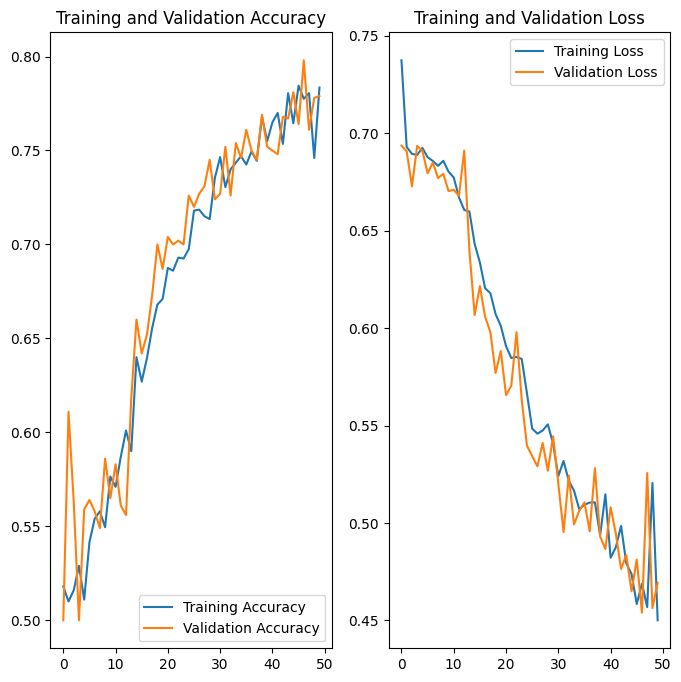

In [19]:
# Plot training and validation loss during training

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()